# **Classification Notebook**

## Objectives

* Fit and evaluate a classification model to predict if a patient will die from Covid-19 or not.

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-covid-19-study/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-covid-19-study'

---

## Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd

train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
test_set_path = "outputs/datasets/cleaned/TestSetCleaned.csv"

TrainSet = pd.read_csv(train_set_path)
TestSet = pd.read_csv(test_set_path)

print(TrainSet.shape)
print(TestSet.shape)
print(TrainSet.head(3))
print(TestSet.head(3))

(49788, 16)
(12448, 16)
    SEX INTUBED PNEUMONIA  AGE DIABETES COPD ASTHMA INMSUPR HIPERTENSION  \
0  Male      No       Yes   47      Yes   No     No      No           No   
1  Male      No       Yes   35       No   No     No      No           No   
2  Male      No       Yes   37      Yes   No     No      No           No   

  OTHER_DISEASE CARDIOVASCULAR OBESITY RENAL_CHRONIC TOBACCO  ICU DIED  
0            No             No     Yes            No      No   No   No  
1            No             No      No            No      No  Yes   No  
2            No             No     Yes            No      No   No  Yes  
      SEX INTUBED PNEUMONIA  AGE DIABETES COPD ASTHMA INMSUPR HIPERTENSION  \
0  Female      No       Yes   56       No   No     No      No           No   
1  Female      No        No   72       No   No     No      No           No   
2  Female      No        No   47      Yes   No     No     Yes          Yes   

  OTHER_DISEASE CARDIOVASCULAR OBESITY RENAL_CHRONIC TOBACCO  ICU 

---

## Step 2: ML Pipeline with all data

#### ML pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder

def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['SEX', 'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD', 
                                                                'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 
                                                                'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 
                                                                'TOBACCO', 'ICU'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", 
                                                               threshold=0.6, selection_method="variance")),
    ])
    return pipeline_base

PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['SEX', 'INTUBED', 'PNEUMONIA',
                                           'DIABETES', 'COPD', 'ASTHMA',
                                           'INMSUPR', 'HIPERTENSION',
                                           'OTHER_DISEASE', 'CARDIOVASCULAR',
                                           'OBESITY', 'RENAL_CHRONIC',
                                           'TOBACCO', 'ICU'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

#### ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        #("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])
    return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for Hyperparameter Optimisation

In [7]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = f"split{i}_test_score"
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

#### Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    TrainSet.drop(['DIED'], axis=1),
    TrainSet['DIED'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(39830, 15) (39830,) (9958, 15) (9958,)


#### Handle Target Imbalance

In [9]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(39830, 15) (39830,) (9958, 15) (9958,)


Check Train Set Target distribution

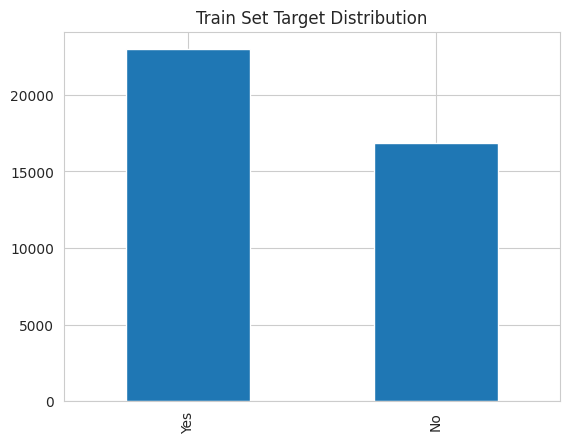

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [11]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(45932, 15) (45932,) (9958, 15) (9958,)


Check Train Set Target distribution after resampling

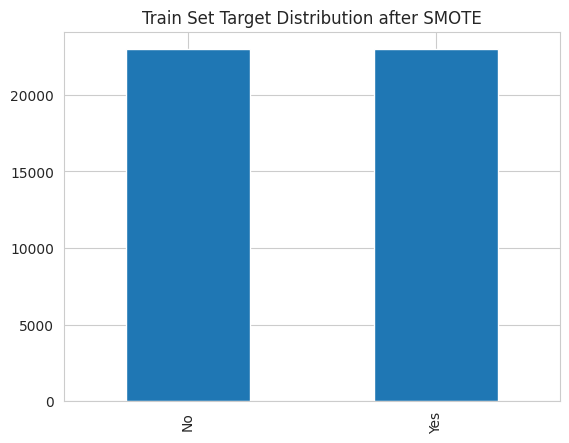

In [12]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution after SMOTE')
plt.show()

#### Grid Search CV - Sklearn
Use standard hyperparameters to find most suitable algorithm

In [13]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

Quick GridSearch CV - Binary Classifier

In [14]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label='Yes'),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


#### Results

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
0,LogisticRegression,0.713695,0.725507,0.736613,0.008233
4,GradientBoostingClassifier,0.715437,0.724636,0.731824,0.00539
6,AdaBoostClassifier,0.710864,0.71497,0.72094,0.004678
1,XGBClassifier,0.693447,0.703126,0.707381,0.005128
3,RandomForestClassifier,0.606358,0.620091,0.636621,0.01082
5,ExtraTreesClassifier,0.55541,0.572193,0.588722,0.011689
2,DecisionTreeClassifier,0.527324,0.544892,0.559983,0.010993


#### Define model and parameters, for Extensive Search

In [16]:
models_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
}

params_search = {
    "XGBClassifier": {
        'learning_rate': [0.1, 0.01, 0.001],
        'max_depth': [3, 6, 10, None],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'min_child_weight': [1, 3, 5],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2]
    }
}

#### Extensive GridSearch CV - Binary Classifier

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

models_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
}

params_search = {
    "XGBClassifier": {
        'learning_rate': [0.1, 0.01, 0.001],
        'max_depth': [3, 6, 10, None],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'min_child_weight': [1, 3, 5],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2]
    }
}

random_search = RandomizedSearchCV(
    estimator=models_search["XGBClassifier"], 
    param_distributions=params_search["XGBClassifier"], 
    n_iter=100,
    scoring=make_scorer(recall_score, pos_label='Yes'),
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=0
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
   

#### Results

In [18]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
0,LogisticRegression,0.713695,0.725507,0.736613,0.008233
4,GradientBoostingClassifier,0.715437,0.724636,0.731824,0.00539
6,AdaBoostClassifier,0.710864,0.71497,0.72094,0.004678
1,XGBClassifier,0.693447,0.703126,0.707381,0.005128
3,RandomForestClassifier,0.606358,0.620091,0.636621,0.01082
5,ExtraTreesClassifier,0.55541,0.572193,0.588722,0.011689
2,DecisionTreeClassifier,0.527324,0.544892,0.559983,0.010993


Get best model name programmatically

In [19]:
best_model = grid_search_summary.iloc[0,0]
best_model

'LogisticRegression'

Parameters for best model

In [20]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{}

Define the best clf pipeline

In [21]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(random_state=0))])

### Assess feature importance

In [22]:
X_train.head(3)

,SEX,INTUBED,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU
0,0,0,0,55,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,45,1,0,0,0,1,0,0,1,0,0,0
2,0,0,0,51,0,0,0,0,1,0,0,0,0,1,0


With the current model, we can assess with .features_importances_

* These are the 15 most important features in descending order. The model was trained on them: 
['PNEUMONIA', 'ICU', 'ASTHMA', 'SEX', 'CARDIOVASCULAR', 'COPD', 'HIPERTENSION', 'INMSUPR', 'OBESITY', 'OTHER_DISEASE', 'RENAL_CHRONIC', 'DIABETES', 'TOBACCO', 'AGE', 'INTUBED']


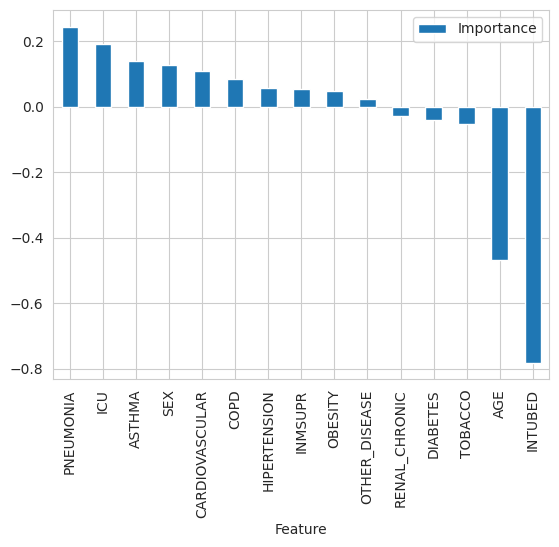

In [23]:
if best_model == 'LogisticRegression':
    feature_importances = pipeline_clf['model'].coef_[0]
else:
    feature_importances = pipeline_clf['model'].feature_importances_

df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns,
    'Importance': feature_importances})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Pipeline on Train and Test Sets

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X, y, pipeline, label_map):
    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=y, y_pred=prediction),
          columns=["Actual " + sub for sub in label_map],
          index=["Prediction " + sub for sub in label_map]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")

def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Evaluation: We cross check with metrics defined at ML business case

- 80% Recall for Churn, on train and test set
- 80% Precision for no Churn on train and test set.

In [25]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map=['No', 'Yes'])

#### Train Set #### 

---  Confusion Matrix  ---
                Actual No  Actual Yes
Prediction No       14136        8830
Prediction Yes       6230       16736


---  Classification Report  ---
              precision    recall  f1-score   support

          No       0.69      0.62      0.65     22966
         Yes       0.65      0.73      0.69     22966

    accuracy                           0.67     45932
   macro avg       0.67      0.67      0.67     45932
weighted avg       0.67      0.67      0.67     45932
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual No  Actual Yes
Prediction No        2542        1621
Prediction Yes       1553        4242


---  Classification Report  ---
              precision    recall  f1-score   support

          No       0.62      0.61      0.62      4163
         Yes       0.72      0.73      0.73      5795

    accuracy                           0.68      9958
   macro avg       0.67      0.67      0.67      9958
weighte

## Step 3: Refit pipeline with best features

### Refit ML Pipeline and Resampling

#### Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [26]:
best_features = ['INTUBED']

In [27]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=best_features)),
    ])
    return pipeline_base

#### Rewrite ML Pipeline for Modelling

In [28]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])
    return pipeline_base

#### Split Train Test Set, considering only with best features

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    TrainSet.drop(['DIED'], axis=1),
    TrainSet['DIED'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(39830, 15) (39830,) (9958, 15) (9958,)


In [30]:
X_train = X_train[best_features]
X_test = X_test[best_features]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(39830, 1) (39830,) (9958, 1) (9958,)


#### Handle Target Imbalance

In [31]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(39830, 1) (39830,) (9958, 1) (9958,)


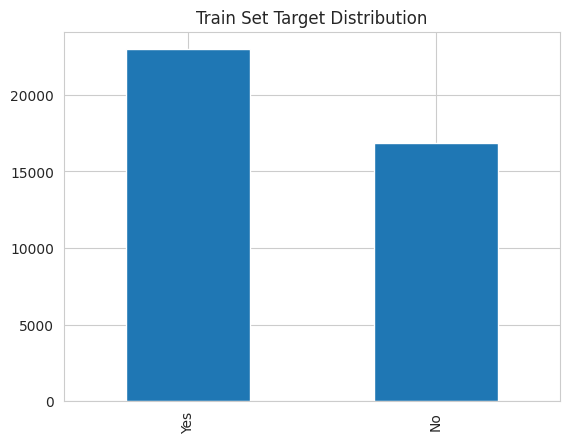

In [32]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [33]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(45932, 1) (45932,) (9958, 1) (9958,)


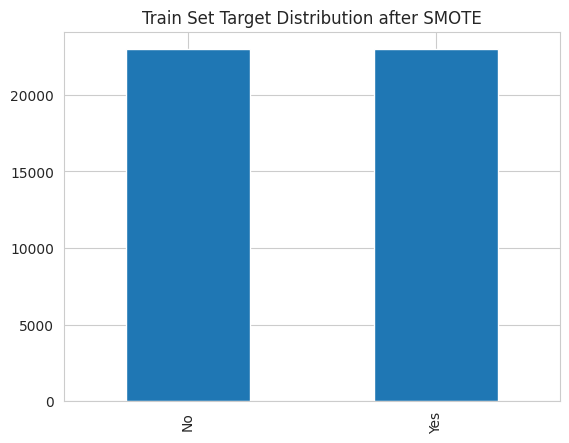

In [34]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution after SMOTE')
plt.show()

#### Grid Search CV: Sklearn

In [35]:
models_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
}

In [36]:
params_search = {
    "XGBClassifier": {
        'model__learning_rate': [0.01],
        'model__max_depth': [3],
    }
}

Grid search

In [37]:
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, pos_label='Yes'),
                 n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Results

In [38]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
print(grid_search_summary)

       estimator min_score mean_score max_score std_score  \
0  XGBClassifier  0.880932   0.885919  0.888526  0.002682   

  model__learning_rate model__max_depth  
0                 0.01                3  


Define the best clf pipeline

In [39]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
print(pipeline_clf)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])


#### Assess feature importance

* These are the 1 most important features in descending order. The model was trained on them: 
['INTUBED']


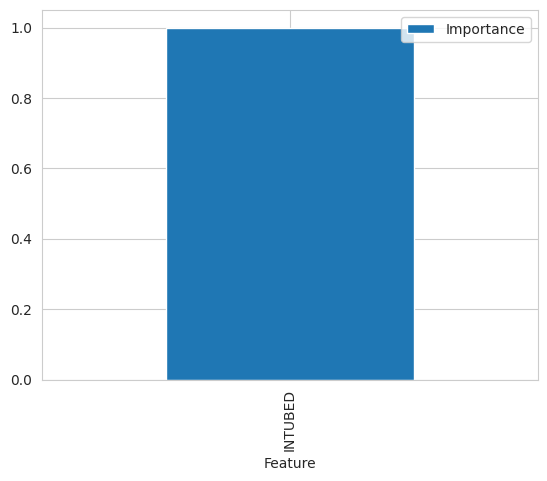

In [40]:
best_features = X_train.columns

df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

#### Evaluate Pipeline on Train and Test Sets

Evaluation: Cross-check with metrics defined in the ML business case.

- 80% Recall for Churn, on train and test set.
- 80% Precision for no Churn on train and test set.

In [41]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map=['No', 'Yes'])

#### Train Set #### 

---  Confusion Matrix  ---
                Actual No  Actual Yes
Prediction No        9627       13339
Prediction Yes       2620       20346


---  Classification Report  ---
              precision    recall  f1-score   support

          No       0.79      0.42      0.55     22966
         Yes       0.60      0.89      0.72     22966

    accuracy                           0.65     45932
   macro avg       0.70      0.65      0.63     45932
weighted avg       0.70      0.65      0.63     45932
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual No  Actual Yes
Prediction No        1738        2425
Prediction Yes        644        5151


---  Classification Report  ---
              precision    recall  f1-score   support

          No       0.73      0.42      0.53      4163
         Yes       0.68      0.89      0.77      5795

    accuracy                           0.69      9958
   macro avg       0.70      0.65      0.65      9958
weighte

## Step 4: Push files to Repo

In [42]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_died/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_died/v1'


#### Train Set

In [43]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

#### Test Set

In [44]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

In [45]:
joblib.dump(value=pipeline_data_cleaning_feat_eng, filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_died/v1/clf_pipeline_model.pkl']

#### Feature Importance plot

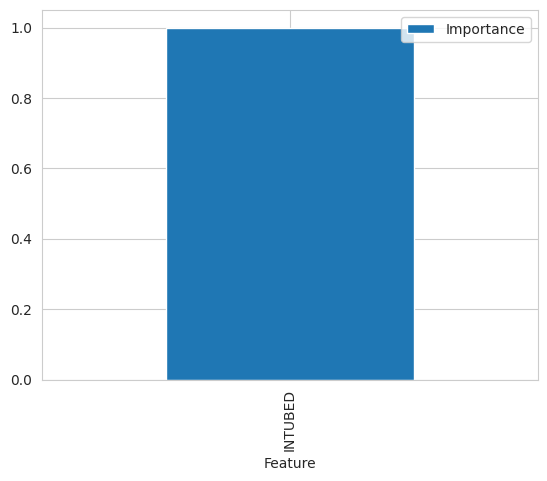

In [46]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')